In [1]:
import magfli as mf
import numpy as np
import matplotlib.pyplot as plt
import swmfio as swmfio

In this journal, we perform a visual validation of the magfli field tracing algorithm.  We trace three field lines based on a magnetic field from a Space Weather Model Framework (SWMF) run.  We begin with a field line that starts on the earth and has curvature.  We overlay the field line with unit vectors (quiver plot) pointing in the direction of the magnetic field, B.  The unit vectors should be tangent to the field line.  The first magnetic field line being traced starts at colatitude 10 degrees, longitude 140 degrees.  Since the field line is in the northern hemisphere, the arrowheads (which are small) should be pointing down.  In the figures below, The field line trace is blue, the B field unit vectors are red.  As expected, the arrows are tangent to the trace and are pointing downward.  

In [2]:
# Pull in the data from the SWMF file

# Location of SWMF file
tmpdir = '/Volumes/Physics HD/runs/DIPTSUR2/GM/IO2/'
filebase = '3d__var_2_e20190902-041400-000'

# Read file contents
batsclass = swmfio.read_batsrus(tmpdir + filebase)

# Get x, y, z and Bx, By, Bz from contents
var_dict = dict(batsclass.varidx)
X = batsclass.data_arr[:,var_dict['x']][:]
Y = batsclass.data_arr[:,var_dict['y']][:]
Z = batsclass.data_arr[:,var_dict['z']][:]

Bx = batsclass.data_arr[:,var_dict['bx']][:]
By = batsclass.data_arr[:,var_dict['by']][:]
Bz = batsclass.data_arr[:,var_dict['bz']][:]


In [3]:
# Set up the process for tracing a field line.

# Determine the box bounding the domain for solution
# We use trace_stop_earth_box that considers whether the trace is outside the earth 
# and inside of the box.
Xmin = [min(X), min(Y), min(Z)]
Xmax = [max(X), max(Y), max(Z)]

# Setup multitrace for tracing field lines 
mt = mf.fieldlines_cartesian_unstructured( X, Y, Z, Bx, By, Bz,
                               Stop_Function = mf.trace_stop_earth_box, 
                               tol = 1e-4, grid_spacing = 1, max_length = 500, 
                               method_ode = 'RK23', method_interp = 'nearest' )



fieldlines.py:__init__(): Initializing fieldlines for fieldlines base class: 0.0001 1 500 RK23
fieldlines.py:__init__(): Initializing fieldlines for unstructured grid: 0.0001 1 500 RK23 nearest


fieldlines.py:trace_field_line(): Tracing field line...[-0.13302222155948898, 0.11161889704894967, 0.984807753012208] False


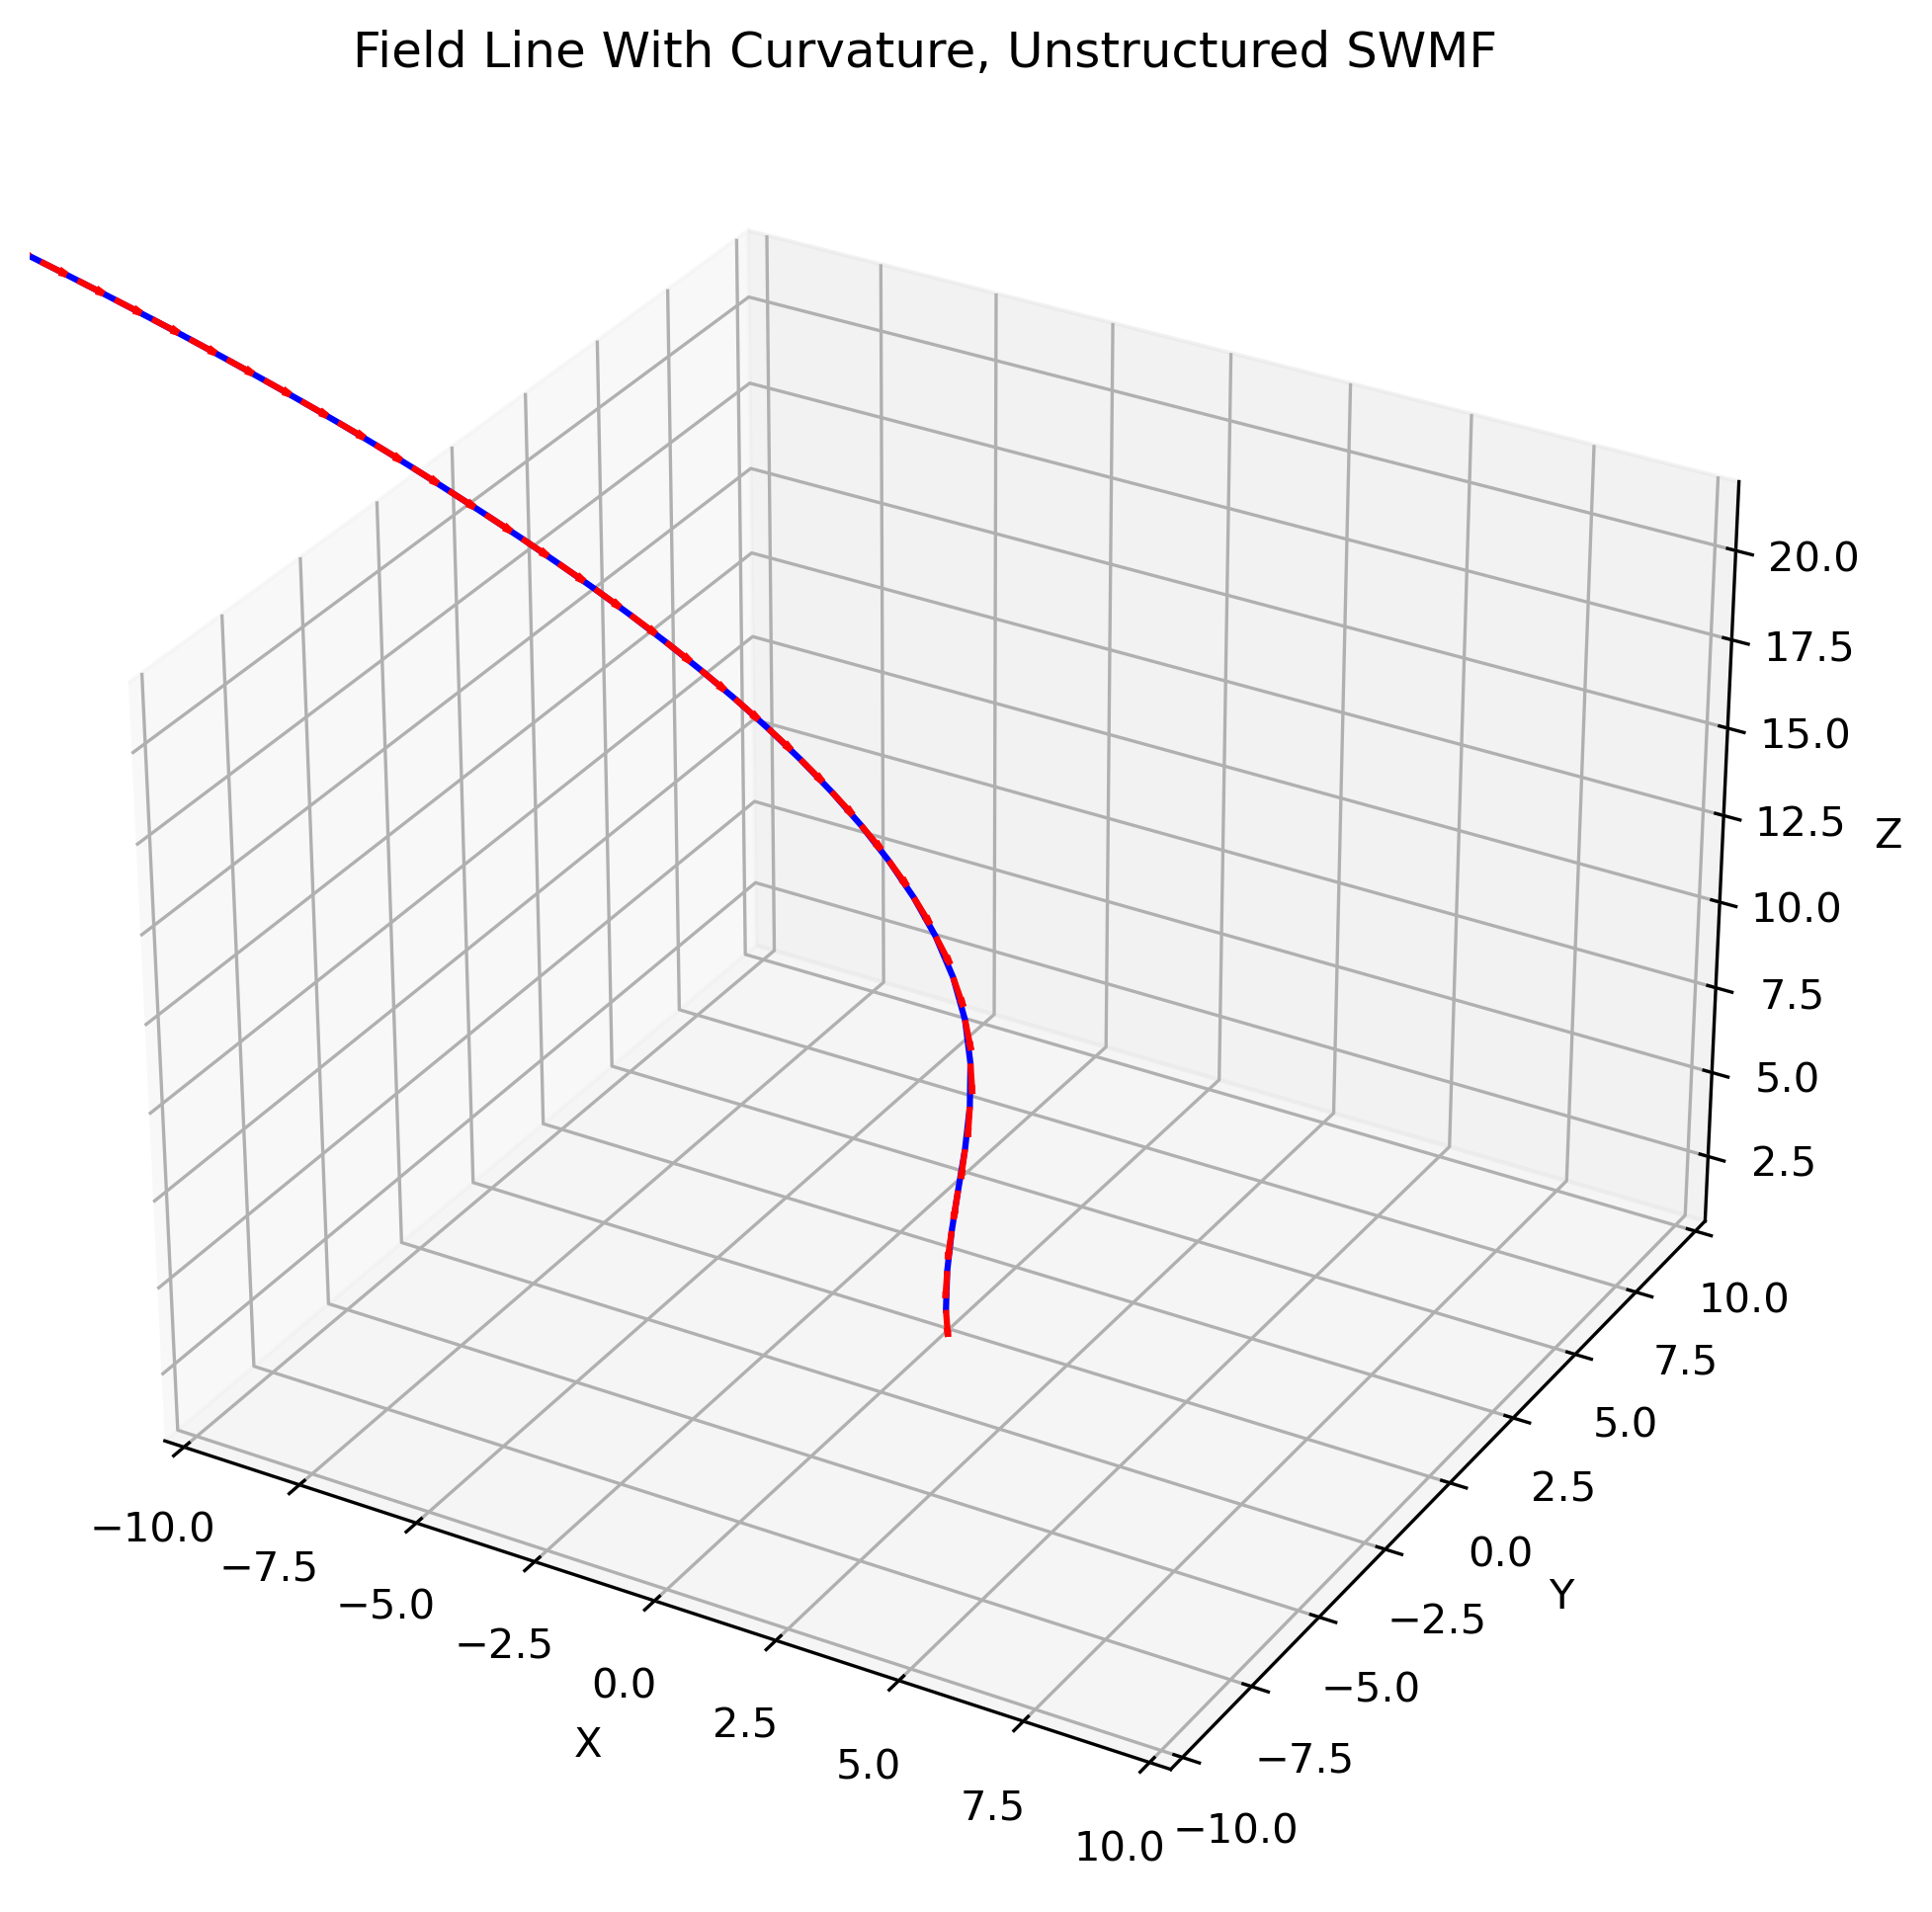

In [4]:
# Examine a field trace with curvature
# Field line starts at the earth's surface in northern hemisphere,
# at colatitude and longitude specified below
col = np.deg2rad(10)  
long = np.deg2rad(140)

# Convert start point to cartesian coordinates
X0 = [ np.cos(long)*np.sin(col), np.sin(long)*np.sin(col), np.cos(col) ]

# Trace field line
field_line = mt.trace_field_line( X0, False )

# Determine B field at points along the field line.
# Normalize B vectors to unit vectors
B_field = np.empty((0,3), float)
shape = np.shape(field_line)
for i in range(shape[1]): 
    # Get point on field line grid, and find B based on SWMF data
    pt = [ field_line[0,i], field_line[1,i], field_line[2,i] ]
    B = mt.field_value(pt)
    B_mag = np.linalg.norm(B)
    B = B/B_mag
    B_field = np.append(B_field, np.array([[B[0], B[1], B[2]]]), axis=0)
    
# Setup plot for field line
fig = plt.figure(figsize=(8,8), dpi=300)
ax = plt.axes(projection='3d')
ax.set_title('Field Line With Curvature, Unstructured SWMF')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Focus plot on region with curvature
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

# Plot field line
ax.plot( field_line[0,:], field_line[1,:], field_line[2,:], color='blue' )

# Plot B unit vectors on field line
ax.quiver(field_line[0,:], field_line[1,:], field_line[2,:], B_field[:,0], B_field[:,1], B_field[:,2], 
          length=0.7, color='red')

We now examine a field line at the front of the domain for the B field.  This field line lies largely in a y-z plane.  As above, we see the B field unit vectors appear to be tangent to the field line.

fieldlines.py:trace_field_line(): Tracing field line...[30.5, 63.0, 63.0] False


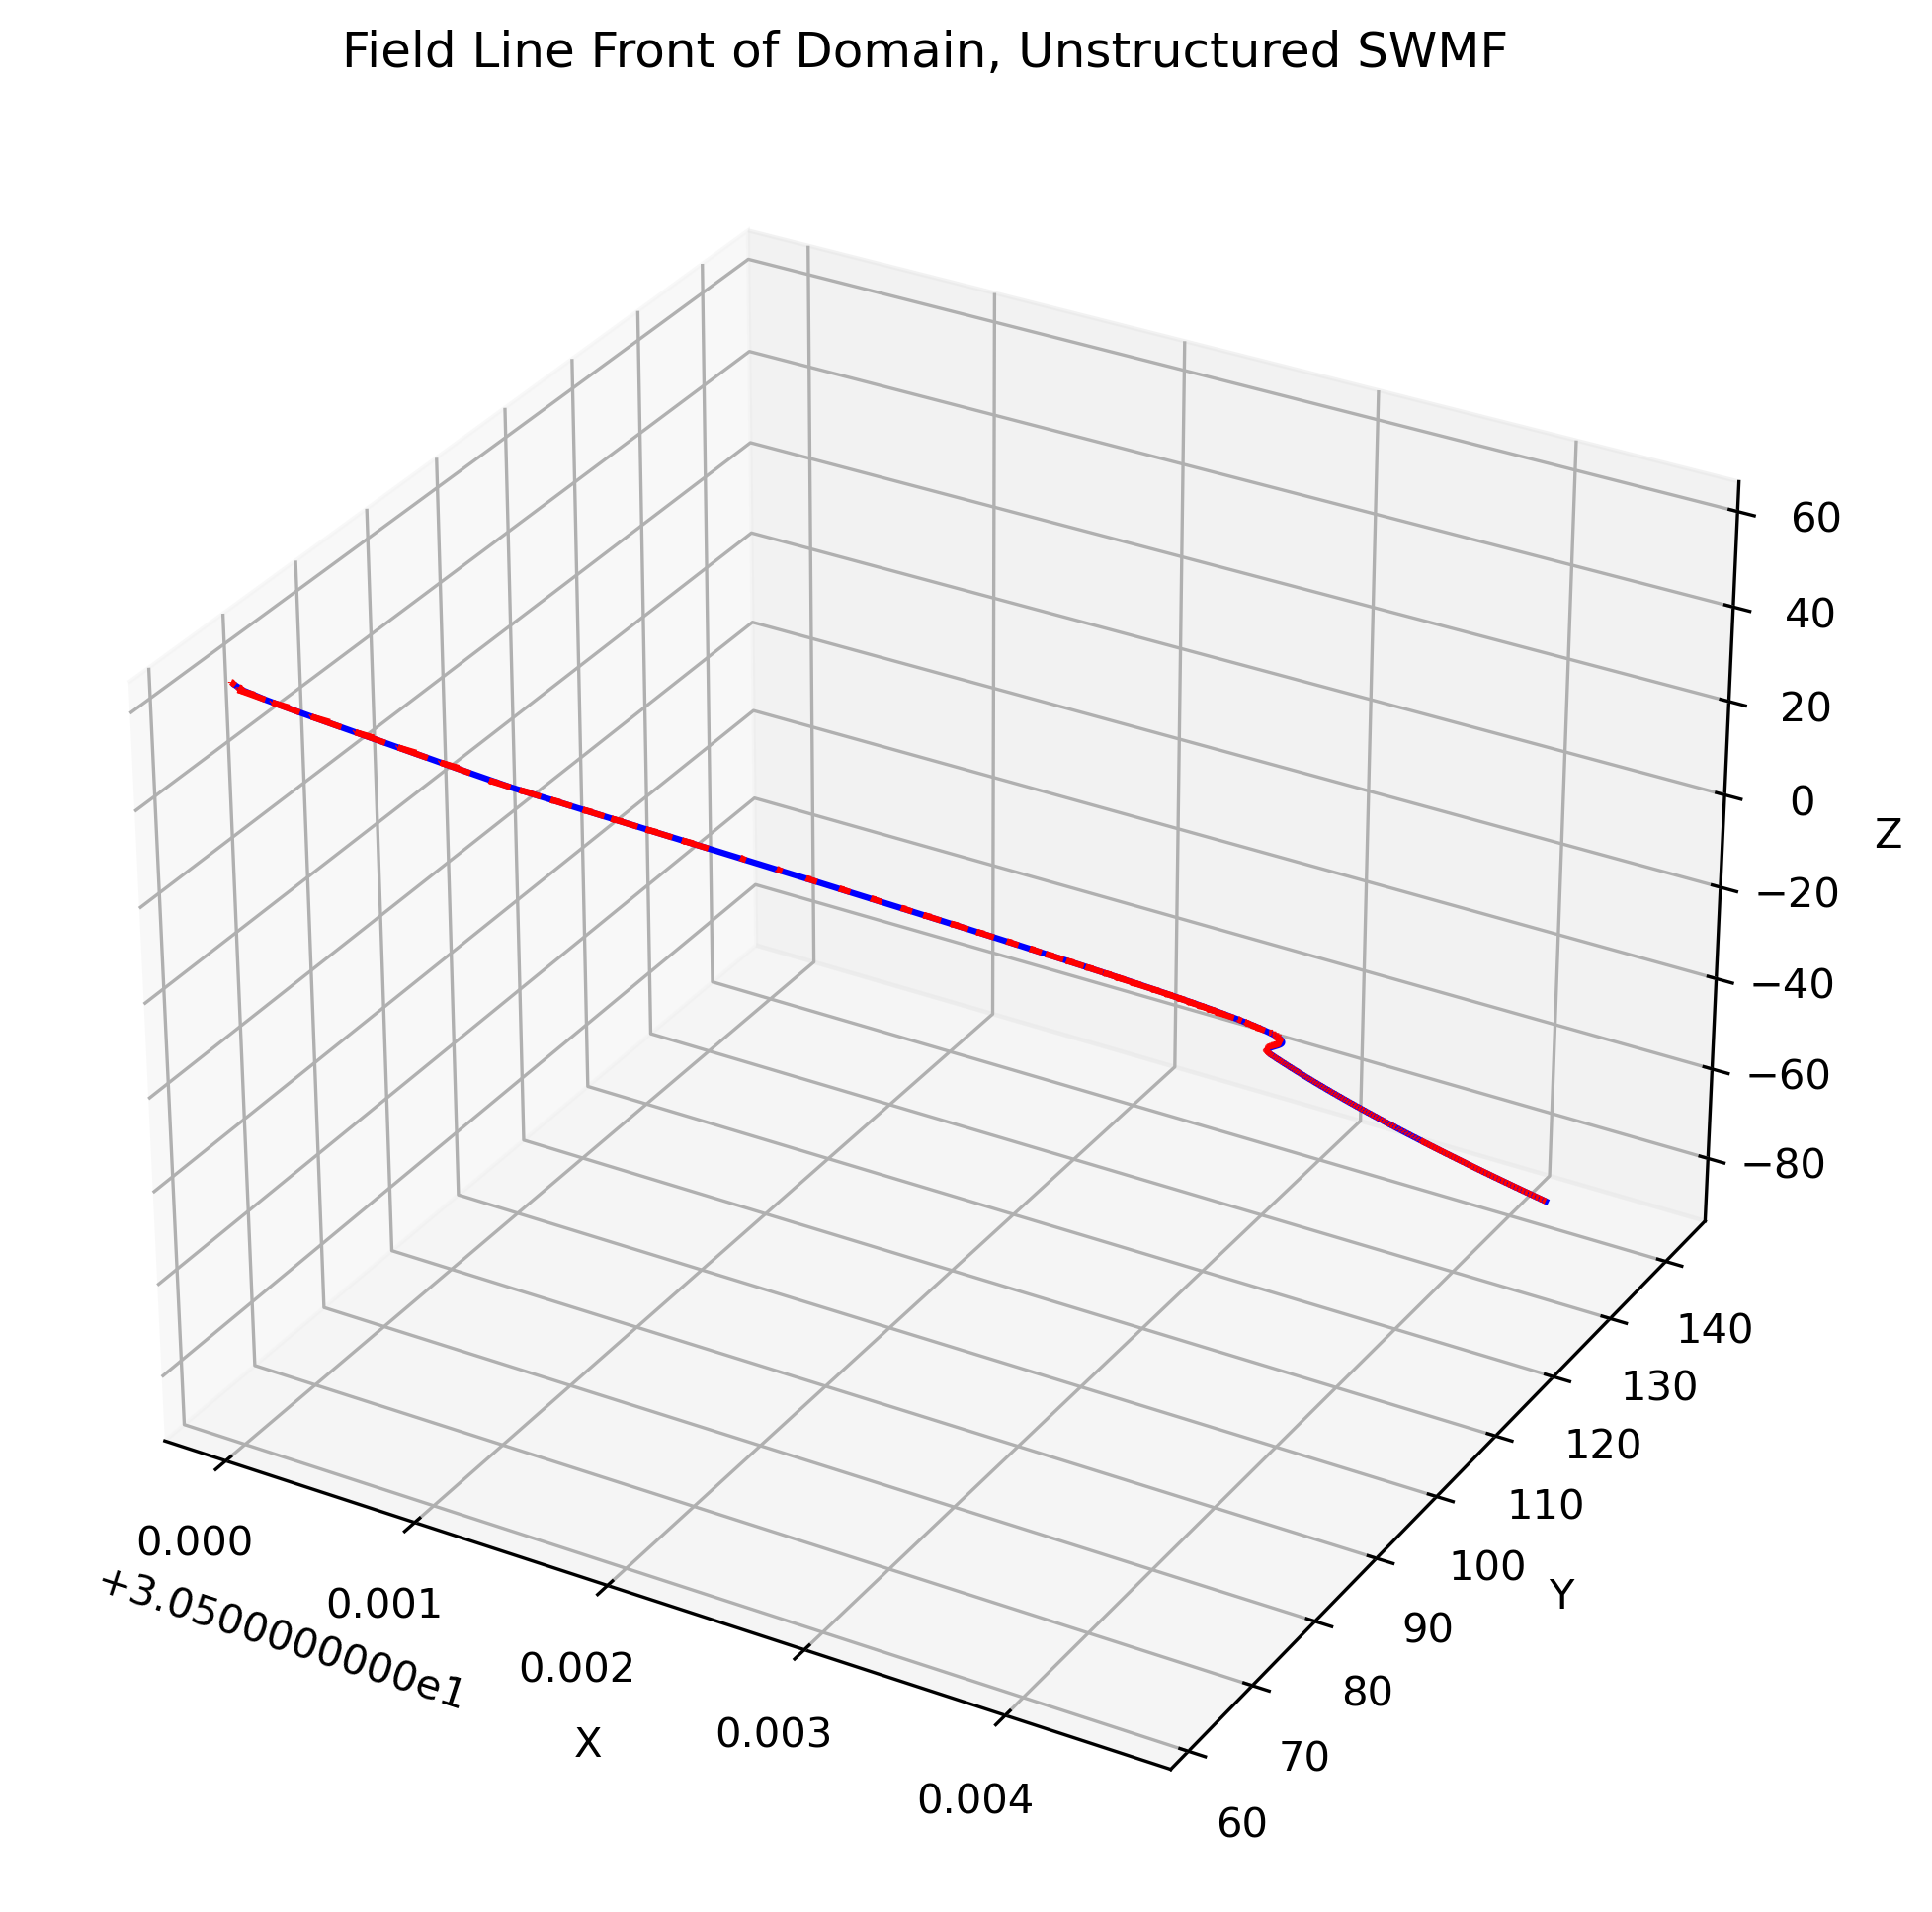

In [5]:
# Examine a field trace on front of domain
X0 = [max(X)-1, max(Y)/2, max(Z)/2]

# Trace field line
field_line = mt.trace_field_line( X0, False )

# Determine B field at points along the field line.
# Normalize B vectors to unit vectors
B_field = np.empty((0,3), float)
shape = np.shape(field_line)
for i in range(shape[1]): 
    # Get point on field line grid, and find B based on SWMF data
    pt = [ field_line[0,i], field_line[1,i], field_line[2,i] ]
    B = mt.field_value(pt)
    B_mag = np.linalg.norm(B)
    B = B/B_mag
    B_field = np.append(B_field, np.array([[B[0], B[1], B[2]]]), axis=0)
    
# Setup plot for field line
fig = plt.figure(figsize=(8,8), dpi=300)
ax = plt.axes(projection='3d')
ax.set_title('Field Line Front of Domain, Unstructured SWMF')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot field line
ax.plot( field_line[0,:], field_line[1,:], field_line[2,:], color='blue' )

# Plot B unit vectors on field line
ax.quiver(field_line[0,:], field_line[1,:], field_line[2,:], B_field[:,0], B_field[:,1], B_field[:,2], 
          length=0.7, color='red')

Last,we examine a field line starting at the bottom of the domain for the B field.  As above, we see the B field unit vectors appear to be tangent to the field line.

fieldlines.py:trace_field_line(): Tracing field line...[-219.0, -126.0, -126.0] False


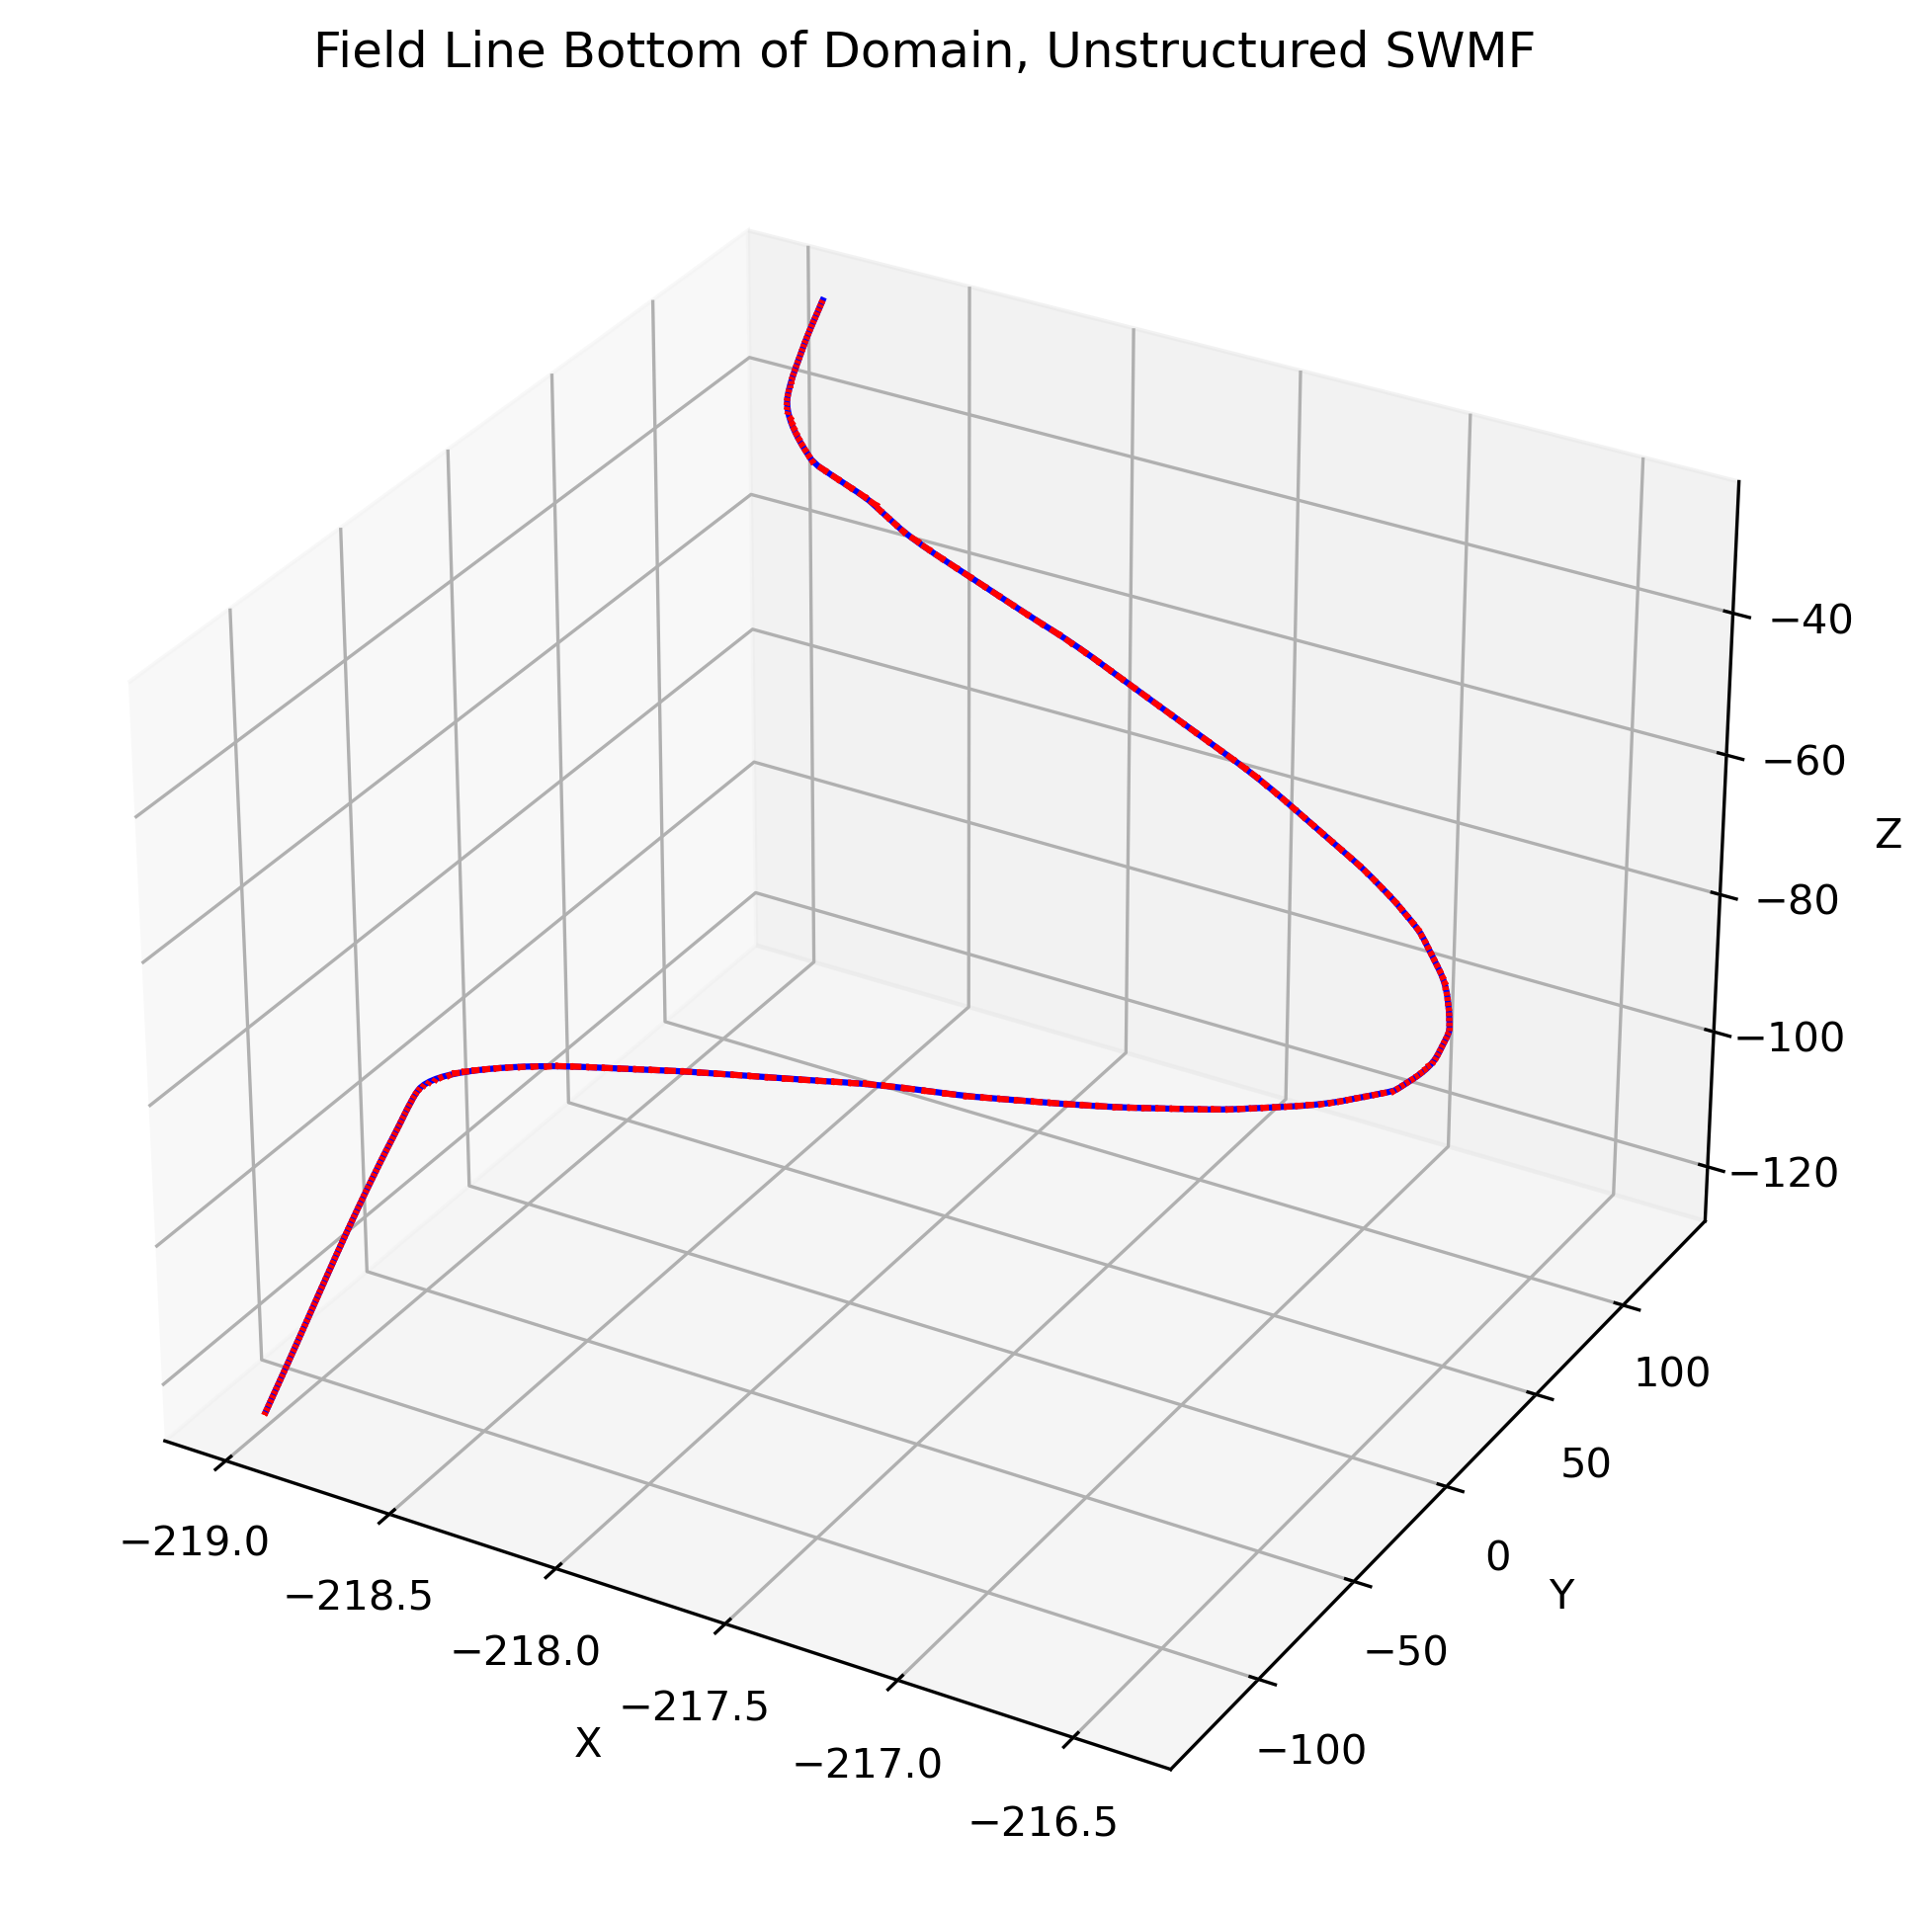

In [6]:
# Examine a field trace starting on bottom of domain
X0 = [min(X)+1, min(Y), min(Z)]

# Trace field line
field_line = mt.trace_field_line( X0, False )

# Determine B field at points along the field line.
# Normalize B vectors to unit vectors
B_field = np.empty((0,3), float)
shape = np.shape(field_line)
for i in range(shape[1]): 
    # Get point on field line grid, and find B based on SWMF data
    pt = [ field_line[0,i], field_line[1,i], field_line[2,i] ]
    B = mt.field_value(pt)
    B_mag = np.linalg.norm(B)
    B = B/B_mag
    B_field = np.append(B_field, np.array([[B[0], B[1], B[2]]]), axis=0)
    
# Setup plot for field line
fig = plt.figure(figsize=(8,8), dpi=300)
ax = plt.axes(projection='3d')
ax.set_title('Field Line Bottom of Domain, Unstructured SWMF')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Focus plot on region with curvature
#ax.set_xlim(-10, 10)
#ax.set_ylim(-10, 10)

# Plot field line
ax.plot( field_line[0,:], field_line[1,:], field_line[2,:], color='blue' )

# Plot B unit vectors on field line
ax.quiver(field_line[0,:], field_line[1,:], field_line[2,:], B_field[:,0], B_field[:,1], B_field[:,2], 
          length=0.7, color='red')